# Libraries and functions initialization

In [4]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 40)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [19]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)
scenario = "chen.2"

registerDoParallel(cores = 4)
number.of.iters <- 100

offset = 0.1
lambda = 1

# Experiments: OWL (dc_loop) versus quantile regression on best 40%

### Two scenarios from Chen2016 (chen.1 and chen.2)

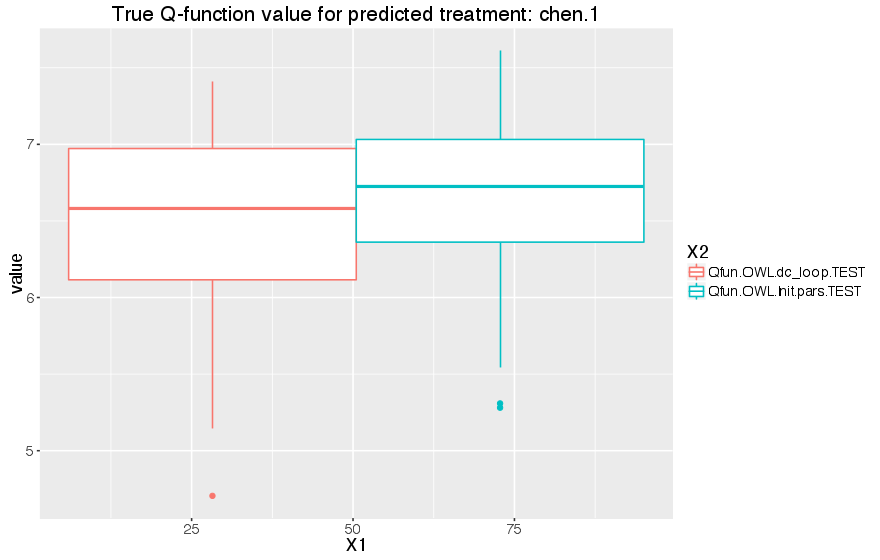

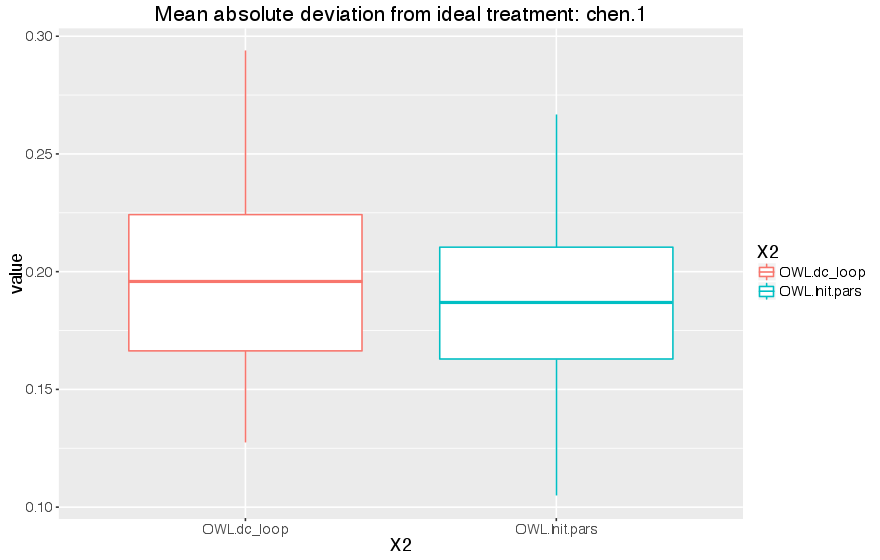

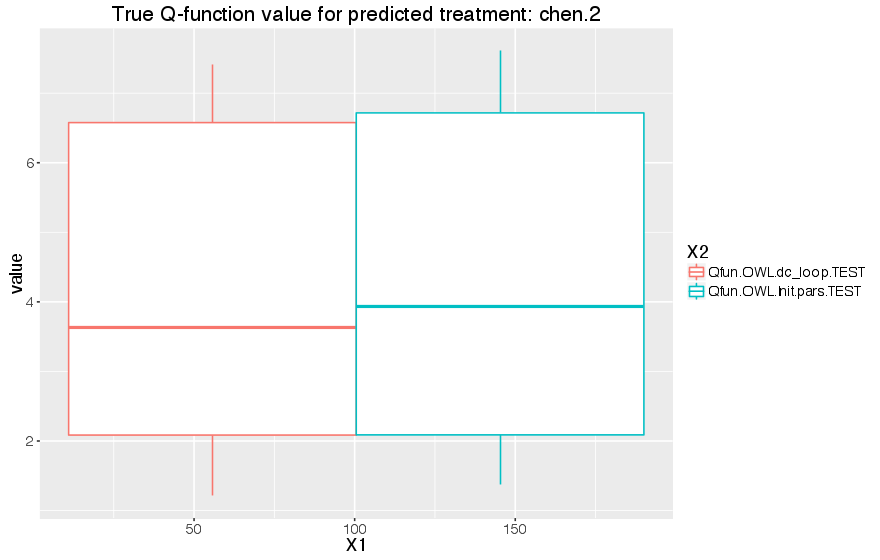

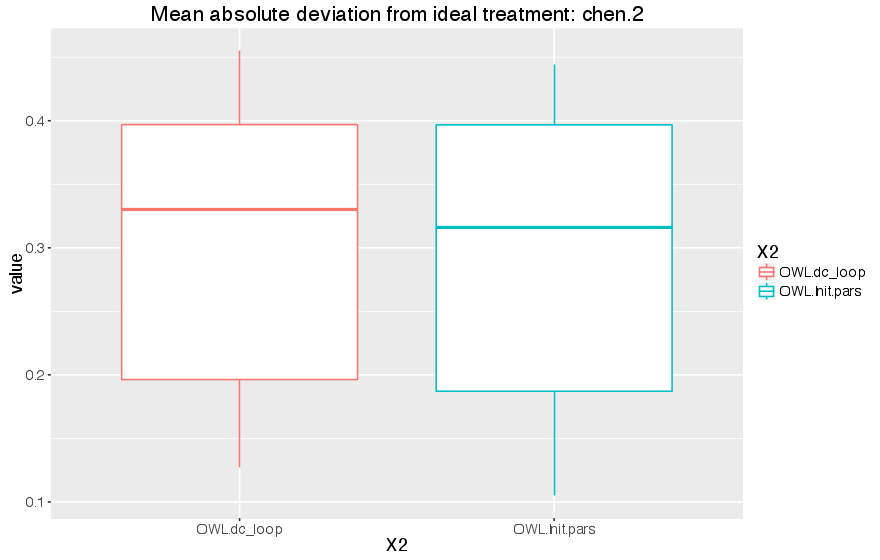

In [20]:
global.stat <- numeric()
global.abs.dev <- numeric()

for (scenario in c("chen.1", "chen.2")) { 
    test <- GetSimulationData(test.data.sample.size, scenario = scenario)
    for (i in seq(1, number.of.iters)) {
        train <- GetSimulationData(sample.size, scenario = scenario)
        init.pars = GetOwlParams(train, lambda, weights = F)
        pars.owl.dc_loop <- GetDCLoopPars(train, offset, lambda, init.pars)


        data.list <- list("train"=train, "test"=test)
        params.list  <- list(
                             "OWL.Init.pars"=init.pars,
                             "OWL.dc_loop"=pars.owl.dc_loop
                            ) 
        iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
        global.stat  <- rbind(global.stat, iter.stat)
        mean.abs.deviation <- sapply(params.list, 
            function(p) with(test, mean(abs(optimal.treatment - PolicyFunLinearKernel(p, covariates)))))
        global.abs.dev <- rbind(global.abs.dev, mean.abs.deviation)

    }

    rownames(global.stat) <- NULL
    q.test <- melt(global.stat[, grep("Q.*TEST", colnames(global.stat))])
    gg <- ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + 
                                     theme(text = element_text(size=15)) +
                                     ggtitle(paste("True Q-function value for predicted treatment:", scenario))
    print(gg)
                                     
    rownames(global.abs.dev) <- NULL
    gg <- ggplot(melt(global.abs.dev)) + geom_boxplot(aes(X2, value,  colour=X2)) + 
                                     theme(text = element_text(size=15)) +
                                     ggtitle(paste("Mean absolute deviation from ideal treatment:", scenario))
    print(gg)
    
}